# Data Processing

In [1]:
from google.colab import drive
import pandas as pd
import ast
drive.mount('/content/drive')

# df = pd.read_csv('/content/drive/MyDrive/ColabNotebooks/Capstone/data_to_lauren(2).csv')

df = pd.read_csv('/content/drive/MyDrive/ColabNotebooks/Capstone/result_df.csv')
df = df[['ipg_index', 'combined_text', 'is_device', 'recommendation']]
df.columns = ['ipg_index', 'text', 'is_device', 'recommendation']

df['text'] = df['text'].apply(ast.literal_eval)
df.head()

Mounted at /content/drive


,ipg_index,text,is_device,recommendation
0,IPG101,"[gastrointestinal, bleeding, suspected, crohn,...",1,standard arrangements
1,IPG105,"[intracranial, aneurysm, intracranial, aneurys...",0,standard arrangements
2,IPG106,"[intracranial, aneurysm, intracranial, aneurys...",0,standard arrangements
3,IPG108,"[deafness, caused, damage, vestibulocochlear, ...",1,standard arrangements
4,IPG110,"[osteoarthritis, metacarpophalangeal, mcp, int...",0,standard arrangements


In [ ]:
device_pred_df = df[['ipg_index', 'text', 'is_device']]

In [2]:
print(df.isna().sum())
df = df.dropna()

ipg_index          0
text               0
is_device          0
recommendation    28
dtype: int64


In [3]:
import numpy as np
df.loc[df['recommendation'].str.contains(',|/'), 'recommendation'] = np.nan
df = df.dropna()

In [4]:
# 假设你的 DataFrame 叫 df，列名为 'recommendation'
df['recommendation'] = df['recommendation'].str.strip().str.lower()

df.recommendation = df.recommendation.apply(lambda x: 'special arrangements' if x.startswith('special') else x)
df.recommendation = df.recommendation.apply(lambda x: 'standard arrangements' if x.startswith('standard') or x.startswith('normal') else x)
df.recommendation = df.recommendation.apply(lambda x: 'only in research' if x.startswith('only') or x.startswith('on') else x)
df.recommendation = df.recommendation.apply(lambda x: 'do not use' if x.startswith('do') else x)

df.recommendation.value_counts()

special arrangements     114
standard arrangements    104
only in research          67
do not use                 9
Name: recommendation, dtype: int64

In [5]:
df['sentences'] = df['text'].apply(' '.join)
df.columns

Index(['ipg_index', 'text', 'is_device', 'recommendation', 'sentences'], dtype='object')

In [6]:
is_device_df = df[df.is_device == 1].reset_index()

In [7]:
is_device_df.drop(columns=['index','is_device','text'], inplace=True)
print(is_device_df.index)

RangeIndex(start=0, stop=198, step=1)


In [8]:
from sklearn.preprocessing import LabelEncoder
LE = LabelEncoder()
is_device_df['label'] = LE.fit_transform(is_device_df['recommendation'])

In [9]:
is_device_df.recommendation.value_counts()

special arrangements     80
standard arrangements    59
only in research         53
do not use                6
Name: recommendation, dtype: int64

In [10]:
## Data Sampling

special_arrangements = is_device_df[is_device_df['recommendation'] == 'special arrangements']
other_arrangements = is_device_df[is_device_df['recommendation'] != 'special arrangements']

# Sample 50 rows from special arrangements
sampled_special_arrangements = special_arrangements.sample(n=55, random_state=42)

# Concatenate the sampled special arrangements with the other arrangements
new_df = pd.concat([sampled_special_arrangements, other_arrangements])

# Reset the index if needed
new_df = new_df.reset_index(drop=True)
new_df['index'] = new_df.index
new_df.head()

,ipg_index,recommendation,sentences,label,index
0,IPG643,special arrangements,thyroid nodules may cystic colloid hyperplasti...,2,0
1,IPG128,special arrangements,patients coronary artery disease cad either si...,2,1
2,IPG618,special arrangements,rectal prolapse may internal also known intuss...,2,2
3,IPG644,special arrangements,anal fistula abnormal tract anal canal skin ar...,2,3
4,IPG601,special arrangements,primary axillary hyperhidrosis typically begin...,2,4


In [11]:
new_df.to_pickle("/content/drive/MyDrive/ColabNotebooks/Capstone/is_device_df.pkl")

# Device Classification

## Data Processing

In [ ]:
device_pred_df['sentences'] = device_pred_df['text'].apply(' '.join)
device_pred_df.head()

In [ ]:
device_pred_df.is_device.value_counts()

In [ ]:
## Data Sampling

is_device = device_pred_df[device_pred_df['is_device'] == 1]
is_not_device = device_pred_df[device_pred_df['is_device'] == 0]

# Sample 50 rows from special arrangements
sampled_is_device = is_device.sample(n=121, random_state=42)

# Concatenate the sampled special arrangements with the other arrangements
new_device_pred_df = pd.concat([sampled_is_device, is_not_device])

# Reset the index if needed
new_device_pred_df = new_device_pred_df.reset_index(drop=True)
new_device_pred_df['index'] = new_device_pred_df.index
new_device_pred_df.head()

In [6]:
new_device_pred_df.is_device.value_counts()

1    121
0    121
Name: is_device, dtype: int64

In [7]:
new_device_pred_df.to_csv("/content/drive/MyDrive/ColabNotebooks/Capstone/device_pred_df.csv")

## Modeling

In [1]:
from google.colab import drive
import pandas as pd
drive.mount('/content/drive')
new_device_pred_df = pd.read_csv("/content/drive/MyDrive/ColabNotebooks/Capstone/device_pred_df.csv")

Mounted at /content/drive


In [2]:
input_col = 'sentences'
output_col = 'is_device'
document_col = 'ipg_index'

text = new_device_pred_df[input_col].values
labels = new_device_pred_df[output_col].values

new_device_pred_df[output_col].nunique()

2

In [3]:
!pip install torchmetrics

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 806.1/806.1 kB 2.8 MB/s eta 0:00:00


In [4]:
import torch
from torch.utils.data import TensorDataset, DataLoader, RandomSampler, SequentialSampler
from transformers import BertTokenizer, BertForSequenceClassification
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder

import pandas as pd
import numpy as np

from tabulate import tabulate
from tqdm import trange
import random
from torchmetrics.classification import Recall, Accuracy, AUROC, Precision

from sklearn.metrics import confusion_matrix

In [5]:
tokenizer = BertTokenizer.from_pretrained('bert-base-uncased', do_lower_case=True)

tokenizer_config.json:   0%|          | 0.00/28.0 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/232k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/466k [00:00<?, ?B/s]

config.json:   0%|          | 0.00/570 [00:00<?, ?B/s]

In [6]:
token_id = []
attention_masks = []

def preprocessing(input_text, tokenizer):
  # Use the tokenizer to preprocess text
  return tokenizer.encode_plus(input_text, add_special_tokens=True, padding='max_length', max_length=128, truncation=True, return_tensors='pt')

# For each sentence, loop and preprocess it
# Put the input ids in the token_id array
# Put the attention_masks in the attention_masks array

for sample in text:
    encoding_dict = preprocessing(sample, tokenizer)
    token_id.append(encoding_dict['input_ids'])
    attention_masks.append(encoding_dict['attention_mask'])

# Concatenate all the elements of token_id into a tensor
token_id = torch.cat(token_id, dim=0)
# Concatenate all the elements of attention_masks
attention_masks = torch.cat(attention_masks, dim=0)
# Make a tensor out of the labels
labels = torch.tensor(labels)

In [7]:
len(labels)

242

In [8]:
torch.save(token_id, '/content/drive/MyDrive/ColabNotebooks/Capstone/device_token_id.pth')
torch.save(attention_masks, '/content/drive/MyDrive/ColabNotebooks/Capstone/device_attention_masks.pth')
torch.save(labels, '/content/drive/MyDrive/ColabNotebooks/Capstone/device_labels.pth')


In [9]:
val_ratio = 0.2
# Pick a recommended batch size from https://arxiv.org/pdf/1810.04805.pdf
batch_size = 16

# Indices of the train and validation splits stratified by labels
train_idx, val_idx = train_test_split(
    range(len(token_id)),
    test_size=val_ratio,
    stratify=labels,
    random_state=42
)

# Train and validation sets
train_set = TensorDataset(token_id[train_idx], attention_masks[train_idx], labels[train_idx])

val_set = TensorDataset(token_id[val_idx], attention_masks[val_idx], labels[val_idx])

# Prepare DataLoader
train_dataloader = DataLoader(
            train_set,
            sampler = RandomSampler(train_set),
            batch_size = batch_size
        )

validation_dataloader = DataLoader(
            val_set,
            sampler = SequentialSampler(val_set),
            batch_size = batch_size
        )

In [10]:
import pickle

with open('/content/drive/MyDrive/ColabNotebooks/Capstone/device_train_idx.pkl', 'wb') as f:
    pickle.dump(train_idx, f)

with open('/content/drive/MyDrive/ColabNotebooks/Capstone/device_val_idx.pkl', 'wb') as f:
    pickle.dump(val_idx, f)

In [11]:
model = BertForSequenceClassification.from_pretrained('bert-base-uncased', num_labels=2, output_attentions = False, output_hidden_states = False)

# See for the optimizer and some learning rates: https://arxiv.org/pdf/1810.04805.pdf
from transformers import AdamW
# from torch.optim import Adam
optimizer = AdamW(model.parameters(), lr=2e-5)

model.safetensors:   0%|          | 0.00/440M [00:00<?, ?B/s]

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at bert-base-uncased and are newly initialized: ['classifier.weight', 'classifier.bias']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
/usr/local/lib/python3.10/dist-packages/transformers/optimization.py:411: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
  warnings.warn(


In [12]:
device = torch.device('mps') if (
    torch.backends.mps.is_available() and torch.backends.mps.is_built()
) else torch.device('cpu')

# If on GPU, do as below
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

_ = model.to(device)

# Recommended number of epochs: See: https://arxiv.org/pdf/1810.04805.pdf
epochs = 2

In [13]:
# Print all the layers of this BERT model and the number of parameters per layer
fine_tune_bert = True

total_parameters = 0

# Loop through all the parameters
# if fine_tune_bert is off, just fine tune the classifer head; otherwise, all parameters
# Also, print out all the parameter names and the number of elements for that parameter
# Finally, accumulate the total number of parameters
# You should get about 110 M
for name, param in model.named_parameters():
    if not fine_tune_bert and "classifier" not in name:
        param.requires_grad = False
    # print(name, param.numel(), param.requires_grad)
    total_parameters += param.numel()

# assert(total_parameters == 109483778)

In [14]:
accuracy = Accuracy(task='binary').to("cpu")
recall = Recall(task='binary').to("cpu")
precision = Precision(task='binary').to("cpu")
auroc = AUROC(task='binary').to("cpu")

In [15]:
# Main training / validation loop
for _ in trange(epochs, desc = 'Epoch'):

    # ========== Training ==========

    # Set model to training mode
    model.train()

    # Tracking variables
    tr_loss = 0
    nb_tr_examples, nb_tr_steps = 0, 0

    for step, batch in enumerate(train_dataloader):

        # map each element of the batch to device
        # Optimize over the batch
        # Do the forward call, etc
        # Remember to zero out the gradients as necessary

        optimizer.zero_grad()

        batch = tuple(t.to(device) for t in batch)
        b_input_ids, b_input_mask, b_labels = batch

        # Forward pass
        train_output = model(b_input_ids, attention_mask=b_input_mask, labels=b_labels)

        loss = train_output.loss

        # Backward pass
        loss.backward()

        # Anything else
        optimizer.step()


        # Update tracking variables
        tr_loss += loss.item()
        nb_tr_examples += b_input_ids.size(0)
        nb_tr_steps += 1


    # ========== Validation ==========

    # Set model to evaluation mode
    model.eval()

    # Tracking variables
    val_accuracy = []
    val_precision = []
    val_recall = []
    val_auroc = []

    for batch in validation_dataloader:
        batch = tuple(t.to(device) for t in batch)
        b_input_ids, b_input_mask, b_labels = batch
        with torch.no_grad():
            # Forward pass
            eval_output = model(b_input_ids, attention_mask=b_input_mask)

        # Calculate validation metrics
        labels = b_labels.to('cpu')
        predicted_labels = torch.argmax(eval_output.logits, dim=1).to('cpu')

        val_accuracy.append(accuracy(predicted_labels, labels))
        val_recall.append(recall(predicted_labels, labels))
        val_precision.append(precision(predicted_labels, labels))
        val_auroc.append(auroc(predicted_labels, labels))

    print('\n\t - Train loss: {:.4f}'.format(tr_loss / nb_tr_steps))
    print('\t - Validation Accuracy: {:.4f}'.format(sum(val_accuracy)/len(val_accuracy)))
    print('\t - Validation Precision: {:.4f}'.format(sum(val_precision)/len(val_precision)))
    print('\t - Validation Recall: {:.4f}'.format(sum(val_recall)/len(val_recall)))
    print('\t - Validation AUROC: {:.4f}\n'.format(sum(val_auroc)/len(val_auroc)))

Epoch:   0%|          | 0/2 [00:00<?, ?it/s]/usr/local/lib/python3.10/dist-packages/torchmetrics/utilities/prints.py:43: UserWarning: No positive samples in targets, true positive value should be meaningless. Returning zero tensor in true positive score
  warnings.warn(*args, **kwargs)  # noqa: B028
Epoch:  50%|█████     | 1/2 [05:34<05:34, 334.32s/it]


	 - Train loss: 0.7183
	 - Validation Accuracy: 0.3750
	 - Validation Precision: 0.3750
	 - Validation Recall: 0.7500
	 - Validation AUROC: 0.3750



Epoch: 100%|██████████| 2/2 [10:37<00:00, 318.77s/it]


	 - Train loss: 0.6581
	 - Validation Accuracy: 0.4844
	 - Validation Precision: 0.4385
	 - Validation Recall: 0.7500
	 - Validation AUROC: 0.4894



In [16]:
torch.save(model.state_dict(), '/content/drive/MyDrive/ColabNotebooks/Capstone/is_device_model.pth')

## Result

In [ ]:
!pip install torchmetrics

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 806.1/806.1 kB 8.1 MB/s eta 0:00:00


In [ ]:
import torch
from torch.utils.data import TensorDataset, DataLoader, RandomSampler, SequentialSampler
from transformers import BertTokenizer, BertForSequenceClassification
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder

import pandas as pd
import numpy as np

from tabulate import tabulate
from tqdm import trange
import random
from torchmetrics.classification import Recall, Accuracy, AUROC, Precision

from sklearn.metrics import confusion_matrix

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
model = BertForSequenceClassification.from_pretrained('bert-base-uncased', num_labels=2, output_attentions = False, output_hidden_states = False)  # Initialize the model class.
model.load_state_dict(torch.load('/content/drive/MyDrive/ColabNotebooks/Capstone/is_device_model.pth'))
model.eval()  # Set the model to evaluation mode

config.json:   0%|          | 0.00/570 [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/440M [00:00<?, ?B/s]

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at bert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


BertForSequenceClassification(
  (bert): BertModel(
    (embeddings): BertEmbeddings(
      (word_embeddings): Embedding(30522, 768, padding_idx=0)
      (position_embeddings): Embedding(512, 768)
      (token_type_embeddings): Embedding(2, 768)
      (LayerNorm): LayerNorm((768,), eps=1e-12, elementwise_affine=True)
      (dropout): Dropout(p=0.1, inplace=False)
    )
    (encoder): BertEncoder(
      (layer): ModuleList(
        (0-11): 12 x BertLayer(
          (attention): BertAttention(
            (self): BertSelfAttention(
              (query): Linear(in_features=768, out_features=768, bias=True)
              (key): Linear(in_features=768, out_features=768, bias=True)
              (value): Linear(in_features=768, out_features=768, bias=True)
              (dropout): Dropout(p=0.1, inplace=False)
            )
            (output): BertSelfOutput(
              (dense): Linear(in_features=768, out_features=768, bias=True)
              (LayerNorm): LayerNorm((768,), eps=1e-12,

In [17]:
model.eval()

BertForSequenceClassification(
  (bert): BertModel(
    (embeddings): BertEmbeddings(
      (word_embeddings): Embedding(30522, 768, padding_idx=0)
      (position_embeddings): Embedding(512, 768)
      (token_type_embeddings): Embedding(2, 768)
      (LayerNorm): LayerNorm((768,), eps=1e-12, elementwise_affine=True)
      (dropout): Dropout(p=0.1, inplace=False)
    )
    (encoder): BertEncoder(
      (layer): ModuleList(
        (0-11): 12 x BertLayer(
          (attention): BertAttention(
            (self): BertSelfAttention(
              (query): Linear(in_features=768, out_features=768, bias=True)
              (key): Linear(in_features=768, out_features=768, bias=True)
              (value): Linear(in_features=768, out_features=768, bias=True)
              (dropout): Dropout(p=0.1, inplace=False)
            )
            (output): BertSelfOutput(
              (dense): Linear(in_features=768, out_features=768, bias=True)
              (LayerNorm): LayerNorm((768,), eps=1e-12,

In [18]:
token_id = torch.load('/content/drive/MyDrive/ColabNotebooks/Capstone/device_token_id.pth')
attention_masks = torch.load('/content/drive/MyDrive/ColabNotebooks/Capstone/device_attention_masks.pth')
labels = torch.load('/content/drive/MyDrive/ColabNotebooks/Capstone/device_labels.pth')

In [19]:
import pickle
with open('/content/drive/MyDrive/ColabNotebooks/Capstone/device_train_idx.pkl', 'rb') as f:
    train_idx = pickle.load(f)

with open('/content/drive/MyDrive/ColabNotebooks/Capstone/device_val_idx.pkl', 'rb') as f:
    val_idx = pickle.load(f)

In [20]:
len(labels)

242

In [28]:
result_df = pd.DataFrame()
# eval_output = model(token_id[val_idx], attention_masks[val_idx])
predicted_labels = torch.argmax(eval_output.logits, dim=1)
result_df['True_Labels'] = labels[val_idx].tolist()
result_df['Predicted_Labels'] = predicted_labels.tolist()
result_df[['Prob_IsNotDevice', 'Prob_IsDevice']] = pd.DataFrame(torch.nn.functional.softmax(eval_output.logits).tolist())
result_df['IPG_index'] = new_device_pred_df[document_col][val_idx].values.tolist()
result_df

<ipython-input-28-3ab64f9589fa>:6: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  result_df[['Prob_IsNotDevice', 'Prob_IsDevice']] = pd.DataFrame(torch.nn.functional.softmax(eval_output.logits).tolist())


,True_Labels,Predicted_Labels,Prob_IsNotDevice,Prob_IsDevice,IPG_index
0,1,1,0.414721,0.585279,IPG771
1,0,1,0.438798,0.561202,IPG686
2,1,1,0.404953,0.595047,IPG699
3,0,0,0.533054,0.466946,IPG110
4,0,1,0.475921,0.524079,IPG59
5,0,1,0.458359,0.541641,IPG357
6,0,1,0.474512,0.525488,IPG668
7,0,1,0.435987,0.564013,IPG678
8,1,1,0.459522,0.540478,IPG623
9,0,0,0.538770,0.461230,IPG106


In [22]:
# Calculate and print the confusion matrix
conf_matrix = confusion_matrix(result_df['True_Labels'], predicted_labels)
print('\nConfusion Matrix:')
print(conf_matrix)


Confusion Matrix:
[[ 7 18]
 [ 0 24]]


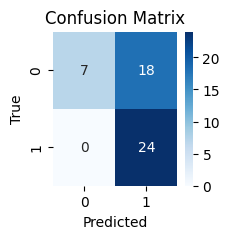

In [26]:
import seaborn as sns
import matplotlib.pyplot as plt
plt.figure(figsize=(2, 2))
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues')
plt.title('Confusion Matrix')
plt.xlabel('Predicted')
plt.ylabel('True')
plt.show()

In [ ]:
result_df.to_csv('/content/drive/MyDrive/ColabNotebooks/Capstone/CNN_device_val')

In [ ]:
# result_df = pd.DataFrame()
# eval_output = model(token_id[train_idx], attention_masks[train_idx])
# predicted_labels = torch.argmax(eval_output.logits, dim=1)
# result_df['True_Labels'] = labels[train_idx].tolist()
# result_df['Predicted_Labels'] = predicted_labels.tolist()
# result_df[['Prob_IsNotDevice', 'Prob_IsDevice']] = pd.DataFrame(torch.nn.functional.sigmoid(eval_output.logits).tolist())
# result_df['IPG_index'] = new_device_pred_df[document_col][train_idx].values.tolist()
# result_df

In [ ]:
# result_df.to_csv('/content/drive/MyDrive/ColabNotebooks/Capstone/CNN_device_train')

# Text Classification
Predicting Recommendations

## Data Loading

In [5]:
from google.colab import drive
import pandas as pd
drive.mount('/content/drive')
new_df = pd.read_pickle("/content/drive/MyDrive/ColabNotebooks/Capstone/is_device_df.pkl")

Mounted at /content/drive


In [6]:
input_col = 'sentences'
output_col = 'label'
document_col = 'ipg_index'

text = new_df[input_col].values
labels = new_df[output_col].values

num_class = new_df[output_col].nunique()
num_class

4

In [ ]:
new_df

,ipg_index,recommendation,sentences,label,index
0,IPG643,special arrangements,thyroid nodules may cystic colloid hyperplasti...,2,0
1,IPG128,special arrangements,patients coronary artery disease cad either si...,2,1
2,IPG618,special arrangements,rectal prolapse may internal also known intuss...,2,2
3,IPG644,special arrangements,anal fistula abnormal tract anal canal skin ar...,2,3
4,IPG601,special arrangements,primary axillary hyperhidrosis typically begin...,2,4
...,...,...,...,...,...
169,IPG769,only in research,aortic valve disease stenosis regurgitation us...,1,169
170,IPG770,standard arrangements,benign prostatic hyperplasia common condition ...,3,170
171,IPG771,only in research,rhinitis inflammation swelling mucous membrane...,1,171
172,IPG8,standard arrangements,symptomatic venous insufficiency common affect...,3,172


In [14]:
new_df[['recommendation', output_col]].value_counts()

recommendation         label
standard arrangements  3        59
special arrangements   2        55
only in research       1        53
do not use             0         6
dtype: int64

## Recommendation with Bert

In [1]:
!pip install torchmetrics

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 806.1/806.1 kB 4.8 MB/s eta 0:00:00


In [2]:
import torch
from torch.utils.data import TensorDataset, DataLoader, RandomSampler, SequentialSampler
from transformers import BertTokenizer, BertForSequenceClassification
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder

import pandas as pd
import numpy as np

from tabulate import tabulate
from tqdm import trange
import random
from torchmetrics.classification import Recall, Accuracy, AUROC, Precision

from sklearn.metrics import confusion_matrix

In [3]:
# Get the tokenizer for BERT, using 'bert-based-uncased'
# Set do_lower_case = True
tokenizer = BertTokenizer.from_pretrained('bert-base-uncased', do_lower_case=True)

# def print_rand_sentence():
#     '''Displays the tokens and respective IDs of a random text sample'''
#     index = random.randint(0, len(text)-1)
#     # Tokenize a random sentence's text and display the token / token id
#     # You might need to use "tabulate" on a certain numpy array

#     # Tokenize a random sentence's text
#     tokens = tokenizer.tokenize(text[index])
#     token_ids = tokenizer.convert_tokens_to_ids(tokens)

#     print(tabulate(np.array([tokens, token_ids]).T, headers=["Token", "Token ID"]))

# print_rand_sentence()

tokenizer_config.json:   0%|          | 0.00/28.0 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/232k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/466k [00:00<?, ?B/s]

config.json:   0%|          | 0.00/570 [00:00<?, ?B/s]

In [7]:
token_id = []
attention_masks = []

def preprocessing(input_text, tokenizer):
  # Use the tokenizer to preprocess text
  return tokenizer.encode_plus(input_text, add_special_tokens=True, padding='max_length', max_length=256, truncation=True, return_tensors='pt')

# For each sentence, loop and preprocess it
# Put the input ids in the token_id array
# Put the attention_masks in the attention_masks array

for sample in text:
    encoding_dict = preprocessing(sample, tokenizer)
    token_id.append(encoding_dict['input_ids'])
    attention_masks.append(encoding_dict['attention_mask'])

# Concatenate all the elements of token_id into a tensor
token_id = torch.cat(token_id, dim=0)
# Concatenate all the elements of attention_masks
attention_masks = torch.cat(attention_masks, dim=0)
# Make a tensor out of the labels
labels = torch.tensor(labels)

In [8]:
torch.save(token_id, '/content/drive/MyDrive/ColabNotebooks/Capstone/token_id.pth')
torch.save(attention_masks, '/content/drive/MyDrive/ColabNotebooks/Capstone/attention_masks.pth')
torch.save(labels, '/content/drive/MyDrive/ColabNotebooks/Capstone/labels.pth')


In [ ]:
# def print_rand_sentence_encoding():
#     '''Displays tokens, token IDs and attention mask of a random text sample'''
#     index = random.randint(0, len(text) - 1)
#     # This should take a random row of token_id and display the tokens, token ids, and attention masks 1/0 values
#     tokens = tokenizer.convert_ids_to_tokens(token_id[index])
#     attention_mask = attention_masks[index]

#     # Display the token, token id, and attention mask using tabulate
#     table_data = list(zip(tokens, token_id[index].tolist(), attention_mask.tolist()))
#     table_headers = ["Tokens", "Token IDs", "Attention Mask"]

#     print(tabulate(table_data, headers=table_headers))

# print_rand_sentence_encoding()

In [9]:
val_ratio = 0.2
# Pick a recommended batch size from https://arxiv.org/pdf/1810.04805.pdf
batch_size = 16

# Indices of the train and validation splits stratified by labels
train_idx, val_idx = train_test_split(
    range(len(token_id)),
    test_size=val_ratio,
    stratify=labels,
    random_state=42
)

# Train and validation sets
train_set = TensorDataset(token_id[train_idx], attention_masks[train_idx], labels[train_idx])

val_set = TensorDataset(token_id[val_idx], attention_masks[val_idx], labels[val_idx])

# Prepare DataLoader
train_dataloader = DataLoader(
            train_set,
            sampler = RandomSampler(train_set),
            batch_size = batch_size
        )

validation_dataloader = DataLoader(
            val_set,
            sampler = SequentialSampler(val_set),
            batch_size = batch_size
        )

In [10]:
import pickle

with open('/content/drive/MyDrive/ColabNotebooks/Capstone/train_idx.pkl', 'wb') as f:
    pickle.dump(train_idx, f)

with open('/content/drive/MyDrive/ColabNotebooks/Capstone/val_idx.pkl', 'wb') as f:
    pickle.dump(val_idx, f)

In [11]:
# Load the BertForSequenceClassification model
# Do not ouput the attentions and all hidden states
model = BertForSequenceClassification.from_pretrained('bert-base-uncased', num_labels=num_class, output_attentions = False, output_hidden_states = False)

# See for the optimizer and some learning rates: https://arxiv.org/pdf/1810.04805.pdf
from transformers import AdamW
# from torch.optim import Adam
optimizer = AdamW(model.parameters(), lr=2e-5)

model.safetensors:   0%|          | 0.00/440M [00:00<?, ?B/s]

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at bert-base-uncased and are newly initialized: ['classifier.weight', 'classifier.bias']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
/usr/local/lib/python3.10/dist-packages/transformers/optimization.py:411: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
  warnings.warn(


In [12]:
device = torch.device('mps') if (
    torch.backends.mps.is_available() and torch.backends.mps.is_built()
) else torch.device('cpu')

# If on GPU, do as below
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

In [13]:
_ = model.to(device)

# Recommended number of epochs: See: https://arxiv.org/pdf/1810.04805.pdf
epochs = 2

In [14]:
# Print all the layers of this BERT model and the number of parameters per layer
fine_tune_bert = True

total_parameters = 0

# Loop through all the parameters
# if fine_tune_bert is off, just fine tune the classifer head; otherwise, all parameters
# Also, print out all the parameter names and the number of elements for that parameter
# Finally, accumulate the total number of parameters
# You should get about 110 M
for name, param in model.named_parameters():
    if not fine_tune_bert and "classifier" not in name:
        param.requires_grad = False
    # print(name, param.numel(), param.requires_grad)
    total_parameters += param.numel()

# assert(total_parameters == 109483778)

In [15]:
# Use torchmetrics to set up accuracy, recall, precision, and auroc
# Put these all on cpu as AUROC does not work on mps due to some bug
accuracy = Accuracy(task='multiclass', num_classes=num_class).to("cpu")
recall = Recall(task='multiclass', num_classes=num_class).to("cpu")
precision = Precision(task='multiclass', num_classes=num_class).to("cpu")
auroc = AUROC(task='multiclass', num_classes=num_class).to("cpu")


In [ ]:
# Main training / validation loop
for _ in trange(epochs, desc = 'Epoch'):

    # ========== Training ==========

    # Set model to training mode
    model.train()

    # Tracking variables
    tr_loss = 0
    nb_tr_examples, nb_tr_steps = 0, 0

    for step, batch in enumerate(train_dataloader):

        # map each element of the batch to device
        # Optimize over the batch
        # Do the forward call, etc
        # Remember to zero out the gradients as necessary

        optimizer.zero_grad()

        batch = tuple(t.to(device) for t in batch)
        b_input_ids, b_input_mask, b_labels = batch

        # Forward pass
        train_output = model(b_input_ids, attention_mask=b_input_mask, labels=b_labels)

        loss = train_output.loss

        # Backward pass
        loss.backward()

        # Anything else
        optimizer.step()


        # Update tracking variables
        tr_loss += loss.item()
        nb_tr_examples += b_input_ids.size(0)
        nb_tr_steps += 1


    # ========== Validation ==========

    # Set model to evaluation mode
    model.eval()

    # Tracking variables
    val_accuracy = []
    val_precision = []
    val_recall = []
    val_auroc = []

    for batch in validation_dataloader:
        batch = tuple(t.to(device) for t in batch)
        b_input_ids, b_input_mask, b_labels = batch
        with torch.no_grad():
            # Forward pass
            eval_output = model(b_input_ids, attention_mask=b_input_mask)

        # Calculate validation metrics
        labels = b_labels.to('cpu')
        predicted_labels = torch.argmax(eval_output.logits, dim=1).to('cpu')

        val_accuracy.append(accuracy(predicted_labels, labels))
        val_recall.append(recall(predicted_labels, labels))
        val_precision.append(precision(predicted_labels, labels))
        val_auroc.append(auroc(eval_output.logits, labels))

    print('\n\t - Train loss: {:.4f}'.format(tr_loss / nb_tr_steps))
    print('\t - Validation Accuracy: {:.4f}'.format(sum(val_accuracy)/len(val_accuracy)))
    print('\t - Validation Precision: {:.4f}'.format(sum(val_precision)/len(val_precision)))
    print('\t - Validation Recall: {:.4f}'.format(sum(val_recall)/len(val_recall)))
    print('\t - Validation AUROC: {:.4f}\n'.format(sum(val_auroc)/len(val_auroc)))


Epoch:   0%|          | 0/2 [00:00<?, ?it/s]

In [ ]:
torch.save(model.state_dict(), '/content/drive/MyDrive/ColabNotebooks/Capstone/model.pth')

## Result

In [1]:
!pip install torchmetrics

In [2]:
import torch
from torch.utils.data import TensorDataset, DataLoader, RandomSampler, SequentialSampler
from transformers import BertTokenizer, BertForSequenceClassification
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder

import pandas as pd
import numpy as np

from tabulate import tabulate
from tqdm import trange
import random
from torchmetrics.classification import Recall, Accuracy, AUROC, Precision

from sklearn.metrics import confusion_matrix

In [3]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [4]:
model = BertForSequenceClassification.from_pretrained('bert-base-uncased', num_labels=4, output_attentions = False, output_hidden_states = False)  # Initialize the model class.
model.load_state_dict(torch.load('/content/drive/MyDrive/ColabNotebooks/Capstone/model.pth'))
model.eval()  # Set the model to evaluation mode

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at bert-base-uncased and are newly initialized: ['classifier.weight', 'classifier.bias']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


BertForSequenceClassification(
  (bert): BertModel(
    (embeddings): BertEmbeddings(
      (word_embeddings): Embedding(30522, 768, padding_idx=0)
      (position_embeddings): Embedding(512, 768)
      (token_type_embeddings): Embedding(2, 768)
      (LayerNorm): LayerNorm((768,), eps=1e-12, elementwise_affine=True)
      (dropout): Dropout(p=0.1, inplace=False)
    )
    (encoder): BertEncoder(
      (layer): ModuleList(
        (0-11): 12 x BertLayer(
          (attention): BertAttention(
            (self): BertSelfAttention(
              (query): Linear(in_features=768, out_features=768, bias=True)
              (key): Linear(in_features=768, out_features=768, bias=True)
              (value): Linear(in_features=768, out_features=768, bias=True)
              (dropout): Dropout(p=0.1, inplace=False)
            )
            (output): BertSelfOutput(
              (dense): Linear(in_features=768, out_features=768, bias=True)
              (LayerNorm): LayerNorm((768,), eps=1e-12,

In [5]:
token_id = torch.load('/content/drive/MyDrive/ColabNotebooks/Capstone/token_id.pth')
attention_masks = torch.load('/content/drive/MyDrive/ColabNotebooks/Capstone/attention_masks.pth')
labels = torch.load('/content/drive/MyDrive/ColabNotebooks/Capstone/labels.pth')

In [6]:
import pickle
with open('/content/drive/MyDrive/ColabNotebooks/Capstone/train_idx.pkl', 'rb') as f:
    train_idx = pickle.load(f)

with open('/content/drive/MyDrive/ColabNotebooks/Capstone/val_idx.pkl', 'rb') as f:
    val_idx = pickle.load(f)

In [15]:
result_df = pd.DataFrame()
# eval_output = model(token_id[val_idx], attention_masks[val_idx])
predicted_labels = torch.argmax(eval_output.logits, dim=1)
result_df['True_Labels'] = labels[val_idx].tolist()
result_df['Predicted_Labels'] = predicted_labels.tolist()
result_df[['Prob_DoNotUse', 'Prob_OnlyInResearch', 'Prob_SpecialArrangements', 'Prob_StandardArrangements']] = pd.DataFrame(torch.nn.functional.softmax(eval_output.logits).tolist())

<ipython-input-15-89d41a40d2ec>:6: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  result_df[['Prob_DoNotUse', 'Prob_OnlyInResearch', 'Prob_SpecialArrangements', 'Prob_StandardArrangements']] = pd.DataFrame(torch.nn.functional.softmax(eval_output.logits).tolist())


In [16]:
result_df['IPG_index'] = new_df[document_col][val_idx].values.tolist()

In [12]:
label_map = {0: 'Do Not Use', 1: 'Only In Research', 2:'Special Arrangements', 3:'Standard Arrangements'}
result_df['True_Labels'] = result_df['True_Labels'].map(label_map)
result_df['Predicted_Labels'] = result_df['Predicted_Labels'].map(label_map)
result_df

,True_Labels,Predicted_Labels,Prob_DoNotUse,Prob_OnlyInResearch,Prob_SpecialArrangements,Prob_StandardArrangements,IPG_index
0,Special Arrangements,Special Arrangements,0.064246,0.306894,0.319765,0.309095,IPG656
1,Only In Research,Special Arrangements,0.067972,0.291754,0.320869,0.319405,IPG658
2,Standard Arrangements,Special Arrangements,0.062114,0.283732,0.328776,0.325378,IPG2
3,Only In Research,Special Arrangements,0.062770,0.296266,0.334095,0.306869,IPG664
4,Standard Arrangements,Standard Arrangements,0.061819,0.283155,0.326819,0.328208,IPG622
5,Standard Arrangements,Special Arrangements,0.063535,0.299781,0.328935,0.307749,IPG118
6,Special Arrangements,Standard Arrangements,0.061848,0.305085,0.307319,0.325748,IPG672
7,Special Arrangements,Special Arrangements,0.065486,0.280653,0.334076,0.319785,IPG582
8,Only In Research,Special Arrangements,0.065956,0.287455,0.329482,0.317108,IPG701
9,Only In Research,Standard Arrangements,0.063312,0.281072,0.321173,0.334443,IPG412


In [ ]:
result_df.to_csv('/content/drive/MyDrive/ColabNotebooks/Capstone/CNN_recommendation_val.csv')

In [17]:
# Calculate and print the confusion matrix
conf_matrix = confusion_matrix(result_df['True_Labels'], predicted_labels)
print('\nConfusion Matrix:')
print(conf_matrix)


Confusion Matrix:
[[ 0  0  2  0]
 [ 0  0  6  4]
 [ 0  0  8  3]
 [ 0  0 12  0]]


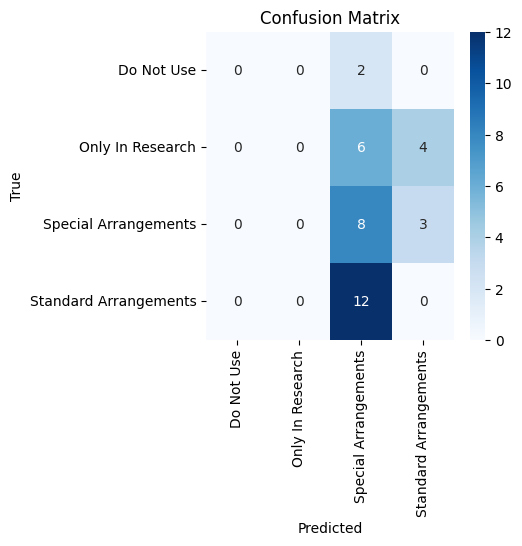

In [20]:
import matplotlib.pyplot as plt
import seaborn as sns
plt.figure(figsize=(4, 4))
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues',
            xticklabels=label_map.values(),
            yticklabels=label_map.values())
plt.title('Confusion Matrix')
plt.xlabel('Predicted')
plt.ylabel('True')
plt.show()

In [ ]:
train_idx_firsthalf, train_idx_lasthalf = train_idx[:68], train_idx[68:]
print(len(train_idx_firsthalf), len(train_idx_lasthalf))

68 68


In [ ]:
result_df2 = pd.DataFrame()
eval_output = model(token_id[train_idx_firsthalf], attention_masks[train_idx_firsthalf])
predicted_labels = torch.argmax(eval_output.logits, dim=1)
result_df2['True_Labels'] = labels[train_idx_firsthalf].tolist()
result_df2['Predicted_Labels'] = predicted_labels.tolist()
result_df2[['Prob_DoNotUse', 'Prob_OnlyInResearch', 'Prob_SpecialArrangements', 'Prob_StandardArrangements']] = pd.DataFrame(torch.nn.functional.softmax(eval_output.logits).tolist())

result_df2['IPG_index'] = new_df[document_col][train_idx_firsthalf].values.tolist()

label_map = {0: 'Do Not Use', 1: 'Only In Research', 2:'Special Arrangements', 3:'Standard Arrangements'}
result_df2['True_Labels'] = result_df2['True_Labels'].map(label_map)
result_df2['Predicted_Labels'] = result_df2['Predicted_Labels'].map(label_map)
result_df2

<ipython-input-9-06aa2041bc5c>:6: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  result_df2[['Prob_DoNotUse', 'Prob_OnlyInResearch', 'Prob_SpecialArrangements', 'Prob_StandardArrangements']] = pd.DataFrame(torch.nn.functional.softmax(eval_output.logits).tolist())


,True_Labels,Predicted_Labels,Prob_DoNotUse,Prob_OnlyInResearch,Prob_SpecialArrangements,Prob_StandardArrangements,IPG_index
0,Only In Research,Only In Research,0.069305,0.326510,0.319628,0.284557,IPG743
1,Only In Research,Special Arrangements,0.062005,0.307894,0.322785,0.307316,IPG655
2,Only In Research,Only In Research,0.069184,0.343348,0.316540,0.270927,IPG676
3,Only In Research,Only In Research,0.068042,0.323634,0.322290,0.286034,IPG757
4,Special Arrangements,Special Arrangements,0.065836,0.294947,0.332560,0.306657,IPG735
...,...,...,...,...,...,...,...
63,Only In Research,Special Arrangements,0.064694,0.305463,0.319590,0.310252,IPG603
64,Standard Arrangements,Special Arrangements,0.063720,0.303787,0.326771,0.305722,IPG748
65,Special Arrangements,Special Arrangements,0.067400,0.301002,0.350541,0.281056,IPG595
66,Only In Research,Special Arrangements,0.064849,0.294657,0.330051,0.310443,IPG761


In [ ]:
result_df2.to_csv('/content/drive/MyDrive/ColabNotebooks/Capstone/CNN_recommendation_train.csv')

In [ ]:
result_df3 = pd.DataFrame()
eval_output = model(token_id[train_idx_lasthalf], attention_masks[train_idx_lasthalf])
predicted_labels = torch.argmax(eval_output.logits, dim=1)
result_df3['True_Labels'] = labels[train_idx_lasthalf].tolist()
result_df3['Predicted_Labels'] = predicted_labels.tolist()
result_df3[['Prob_DoNotUse', 'Prob_OnlyInResearch', 'Prob_SpecialArrangements', 'Prob_StandardArrangements']] = pd.DataFrame(torch.nn.functional.softmax(eval_output.logits).tolist())

result_df3['IPG_index'] = new_df[document_col][train_idx_lasthalf].values.tolist()

label_map = {0: 'Do Not Use', 1: 'Only In Research', 2:'Special Arrangements', 3:'Standard Arrangements'}
result_df3['True_Labels'] = result_df3['True_Labels'].map(label_map)
result_df3['Predicted_Labels'] = result_df3['Predicted_Labels'].map(label_map)
result_df3

<ipython-input-10-58e25c3f6d4e>:6: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  result_df3[['Prob_DoNotUse', 'Prob_OnlyInResearch', 'Prob_SpecialArrangements', 'Prob_StandardArrangements']] = pd.DataFrame(torch.nn.functional.softmax(eval_output.logits).tolist())


,True_Labels,Predicted_Labels,Prob_DoNotUse,Prob_OnlyInResearch,Prob_SpecialArrangements,Prob_StandardArrangements,IPG_index
0,Special Arrangements,Special Arrangements,0.066486,0.281296,0.337264,0.314953,IPG743
1,Standard Arrangements,Standard Arrangements,0.064046,0.265604,0.317034,0.353316,IPG655
2,Only In Research,Special Arrangements,0.062028,0.307922,0.329806,0.300244,IPG676
3,Only In Research,Special Arrangements,0.068392,0.299265,0.332371,0.299971,IPG757
4,Standard Arrangements,Standard Arrangements,0.063015,0.297600,0.304646,0.334739,IPG735
...,...,...,...,...,...,...,...
63,Only In Research,Only In Research,0.068777,0.322139,0.318344,0.290740,IPG603
64,Standard Arrangements,Standard Arrangements,0.064596,0.274262,0.322097,0.339046,IPG748
65,Standard Arrangements,Standard Arrangements,0.067354,0.268220,0.320671,0.343754,IPG595
66,Only In Research,Only In Research,0.069607,0.330990,0.327216,0.272186,IPG761


In [ ]:
result_df3.to_csv('/content/drive/MyDrive/ColabNotebooks/Capstone/CNN_recommendation_train2.csv')